In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import PCA 

In [2]:
df = pd.read_csv('breast-cancer.csv')
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


# Preprocessing

In [27]:
df = df.iloc[:, 1:]  # Remove the id column
df = df.dropna()  # Drop rows with missing values

In [4]:
X = df.drop('diagnosis', axis=1)
y = df['diagnosis'].map({'M': 1, 'B': 0})  # Map 'M' to 1 and 'B' to 0

In [5]:
X_scaled = MinMaxScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Training and Evaluating SVM Model

## Linear Kernel

In [8]:
svm = SVC(kernel='linear', random_state=42)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.98


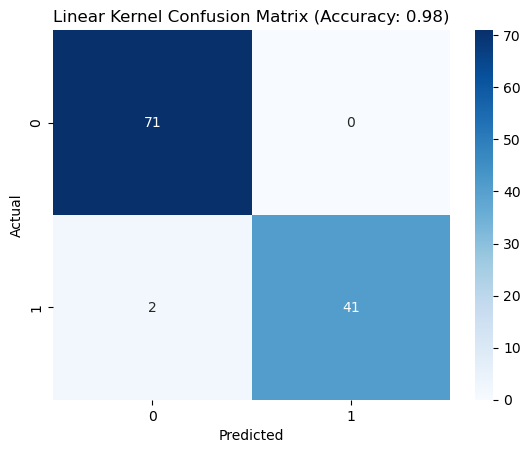

In [30]:
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title(f'Linear Kernel Confusion Matrix (Accuracy: {accuracy:.2f})')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## RBF Kernel

In [9]:
svm_rbf = SVC(kernel='rbf', random_state=42)
svm_rbf.fit(X_train, y_train)
y_pred_rbf = svm_rbf.predict(X_test)
accuracy_rbf = accuracy_score(y_test, y_pred_rbf)
conf_matrix_rbf = confusion_matrix(y_test, y_pred_rbf)
print(f"Accuracy: {accuracy_rbf:.2f}")

Accuracy: 0.97


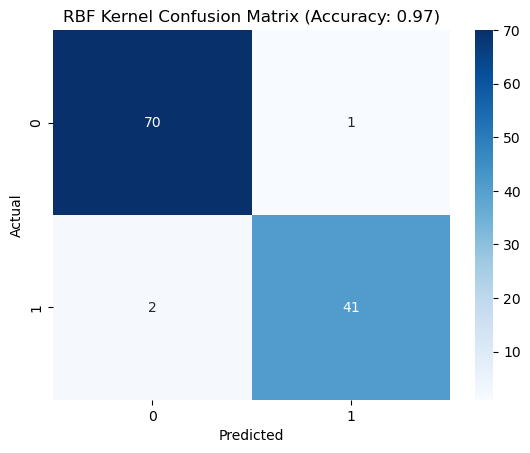

In [31]:
sns.heatmap(conf_matrix_rbf, annot=True, fmt='d', cmap='Blues')
plt.title(f'RBF Kernel Confusion Matrix (Accuracy: {accuracy_rbf:.2f})')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Hyperparameter Tuning

In [17]:
grid = {'C': [0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1],'kernel': ['rbf', 'linear']}
GS = GridSearchCV(SVC(), grid, cv=5, n_jobs=-1)
GS.fit(X_train, y_train)
print("Best parameters:", GS.best_params_)
print("Best score:", GS.best_score_)

Best parameters: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
Best score: 0.9802197802197803


# Cross Validation

In [18]:
cross_val_scores = cross_val_score(GS.best_estimator_, X_scaled, y, cv=5)
print("Cross-validation scores:", cross_val_scores)

Cross-validation scores: [0.96491228 0.96491228 0.99122807 0.96491228 0.98230088]


# Plotting Decision Boundary by reducing dimensioanlity using PCA

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, test_size=0.2, random_state=42)

## Linear Kernel

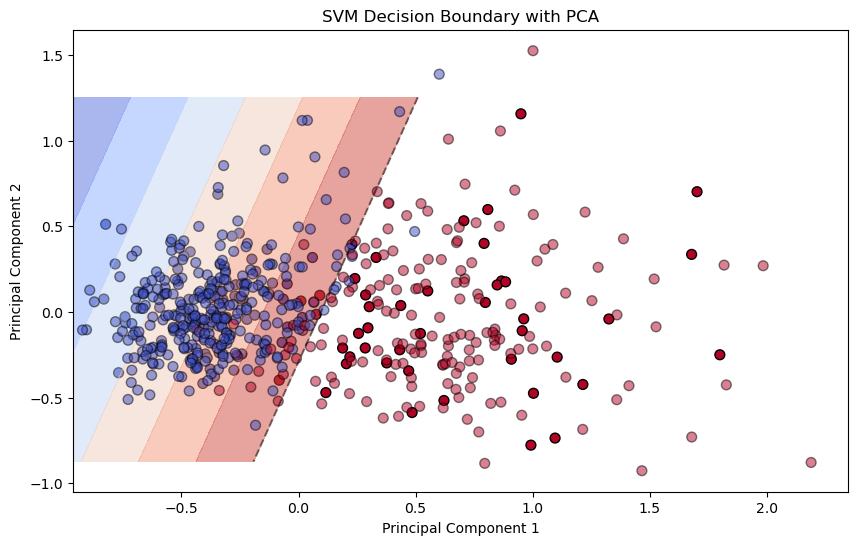

In [ ]:
svm_pca = SVC(kernel='linear', random_state=42)
svm_pca.fit(X_train_pca, y_train_pca)
y_pred_pca = svm_pca.predict(X_test_pca)

# decision boundary visualization
plt.figure(figsize=(10, 6))
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test_pca, cmap='coolwarm', edgecolors='k', s=50)
plt.title('SVM Decision Boundary with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
xlim = plt.xlim()
ylim = plt.ylim()
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 100), np.linspace(ylim[0], ylim[1], 100))
Z = svm_pca.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap='coolwarm', alpha=0.5)
plt.contour(xx, yy, Z, colors='k', levels=[0], alpha=0.5, linestyles='--')
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train_pca, cmap='coolwarm', edgecolors='k', s=50, alpha=0.5)
plt.show()

## RBF Kernel

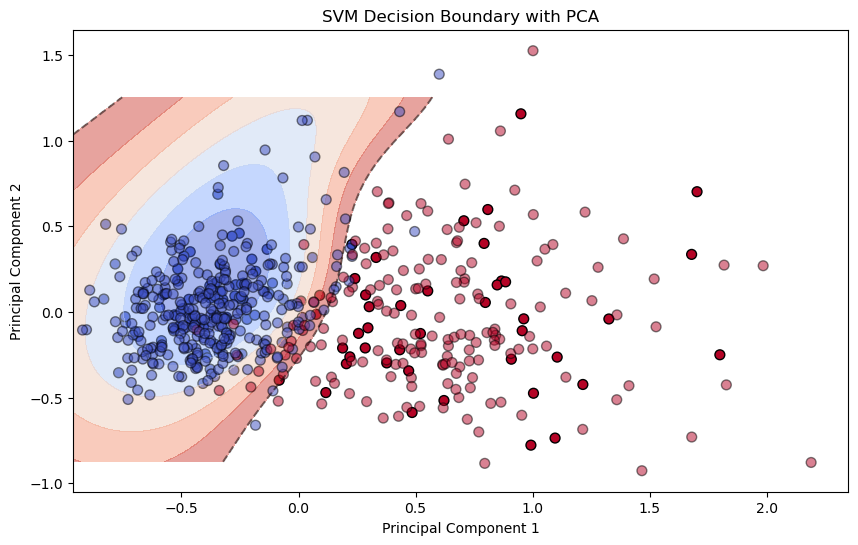

In [29]:
svm_pca = SVC(kernel='rbf', random_state=42)
svm_pca.fit(X_train_pca, y_train_pca)
y_pred_pca = svm_pca.predict(X_test_pca)

# decision boundary visualization
plt.figure(figsize=(10, 6))
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test_pca, cmap='coolwarm', edgecolors='k', s=50)
plt.title('SVM Decision Boundary with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
xlim = plt.xlim()
ylim = plt.ylim()
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 100), np.linspace(ylim[0], ylim[1], 100))
Z = svm_pca.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap='coolwarm', alpha=0.5)
plt.contour(xx, yy, Z, colors='k', levels=[0], alpha=0.5, linestyles='--')
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train_pca, cmap='coolwarm', edgecolors='k', s=50, alpha=0.5)
plt.show()